In [1]:
# loading in SMAP data from txt file I downloaded from 
# https://airmoss.ornl.gov/visualize/index.html?data=smap&lon=-79.10&lat=35.98
# (with different coordinates that I inputted)

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import os,sys
from osgeo import gdal
%matplotlib  widget

In [2]:
# Read in text file 
#sm = np.loadtxt('SMAP_daily_32.4642_-115.4803.txt', delimiter=',', skiprows=7, dtype=str)
sm = np.loadtxt('SMAP_daily_32.4609_-115.5273.txt', delimiter=',', skiprows=7, dtype=str)

In [3]:
dates = sm[:,0]
# make the dates into datetime objects
sm_dates=[]
for i in range(0,len(dates)):
    sm_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y-%m-%d'))
print(np.shape(sm_dates))

(2264,)


In [4]:
sm_surface_str = sm[:,6]
sm_root_str = sm[:,7]
#print(sm_surface_str[87:100])
#print(sm_root_str[87:100])
#print(type(sm_root_str[0]))
# each array entry is min:mean:max for that day (string)
#print(np.shape(sm_surface_str))
#print(np.shape(sm_root_str))
numDates = np.shape(sm_dates)[0]
print(str(numDates)+' dates of soil moisture data')

2264 dates of soil moisture data


In [5]:
# turn the strings in these arrays into floats 
#initialize arrays
surface_min = np.ndarray([numDates],dtype='float')
surface_mean = np.ndarray([numDates],dtype='float')
surface_max = np.ndarray([numDates],dtype='float')
root_min = np.ndarray([numDates],dtype='float')
root_mean = np.ndarray([numDates],dtype='float')
root_max = np.ndarray([numDates],dtype='float')
for i in np.arange(86,numDates):
    #print(sm_surface_str[i])
    # min
    temp_min = re.sub("\\;.*","",sm_surface_str[i])
    if temp_min == '':
        surface_min[i] = np.nan
    else:
        surface_min[i] = float(temp_min)
    temp_min = re.sub("\\;.*","",sm_root_str[i])
    if temp_min == '':
        root_min[i] = np.nan
    else:
        root_min[i] = float(temp_min)
    # mean 
    temp_mean = re.sub(".*\;\\;.*","",sm_surface_str[i])
    q = ';'
    s = sm_surface_str[i]
    temp_mean = s[s.find(q)+len(q):s.rfind(q)]
    if temp_mean == '':
        surface_mean[i] = np.nan
    else:
        surface_mean[i] = float(temp_mean)
    temp_mean = re.sub(".*\;\\;.*","",sm_root_str[i])
    s = sm_root_str[i]
    temp_mean = s[s.find(q)+len(q):s.rfind(q)]
    if temp_mean == '':
        root_mean[i] = np.nan
    else:
        root_mean[i] = float(temp_mean)
    # max
    temp_max = re.sub(".*\\;","",sm_surface_str[i])
    if temp_max == '':
        surface_max[i] = np.nan
    else:
        surface_max[i] = float(temp_max)   
    temp_max = re.sub(".*\\;","",sm_root_str[i])
    if temp_max == '':
        root_max[i] = np.nan
    else:
        root_max[i] = float(temp_max)

In [6]:
# Read in raw precipitation data and plot it 
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip.txt', delimiter=',', skiprows=3, dtype=str)
precipDates = precip[:,0]
precip = precip[:,1]
#print(type(precip[0]))
precip = precip.astype(float)
#print(precip)
# convert to cm from inches 
precip = precip*2.54
# make the dates from precip.txt into datetime objects
my_dates=[]
for i in range(0,len(precipDates)):
    my_dates.append(datetime.strptime(str(precipDates[i]).replace('\n',''), '%Y-%m-%d'))

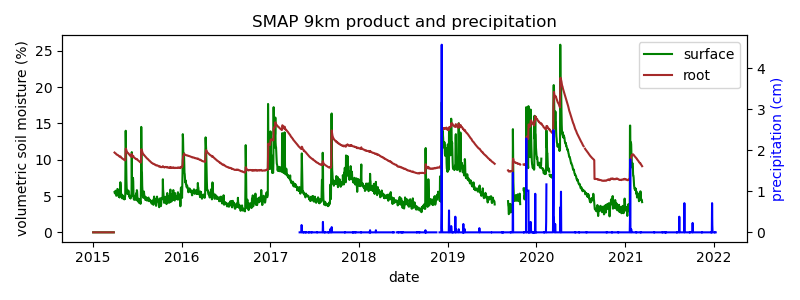

In [7]:
fig, ax1 =plt.subplots(figsize=(8,3), tight_layout=True)
ax1.plot(sm_dates, surface_mean,'-g',label='surface')
ax1.plot(sm_dates, root_mean,'-',color='brown',label='root')
ax1.set_ylabel('volumetric soil moisture (%)')
ax1.set_xlabel('date')
ax2 = ax1.twinx()
ax2.plot(my_dates, precip,'-b',label='precip')
ax2.set_ylabel('precipitation (cm)',color='b')
ax1.legend()
#plt.xlim([np.min(my_dates), np.max(my_dates)])
plt.title('SMAP 9km product and precipitation')
plt.show()

In [8]:
# just pull out the dates of the slcs from the soil moisture log 
# find which dates both datasets have in common 
overlap_dates, sm_dates_overlap, my_dates_overlap = np.intersect1d(sm_dates, my_dates, return_indices=True)

num_overlap_dates = len(overlap_dates)
print(num_overlap_dates)
print(sm_dates_overlap)
print(my_dates_overlap)

# initialize empty array for data on overlapping days to go in 
overlap_data = np.zeros([3, num_overlap_dates], dtype='float')
# first row precip
# second row surface sm 
# third row root sm 

# now loop through these dates that are shared btw datasets 
for i in range(num_overlap_dates):
    overlap_data[0,i] = precip[my_dates_overlap[i]]
    overlap_data[1,i] = surface_mean[sm_dates_overlap[i]]
    overlap_data[2,i] = root_mean[sm_dates_overlap[i]]

1413
[ 850  851  852 ... 2261 2262 2263]
[   0    1    2 ... 1410 1411 1412]


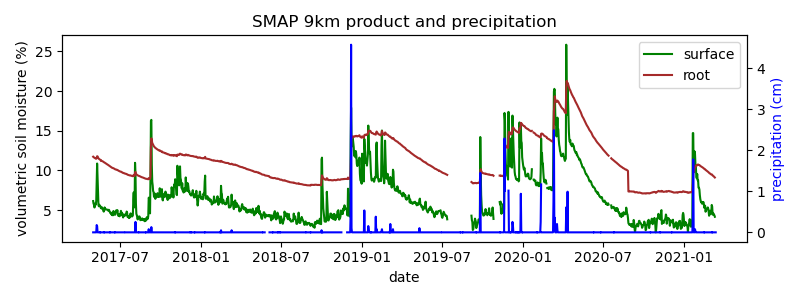

In [9]:
# now check that I did it right in the cell above 
fig, ax1 =plt.subplots(figsize=(8,3), tight_layout=True)
ax1.plot(overlap_dates, overlap_data[1,:],'-g',label='surface')
ax1.plot(overlap_dates, overlap_data[2,:],'-',color='brown',label='root')
ax1.set_ylabel('volumetric soil moisture (%)')
ax1.set_xlabel('date')
ax2 = ax1.twinx()
ax2.plot(overlap_dates, overlap_data[0,:],'-b',label='precip')
ax2.set_ylabel('precipitation (cm)',color='b')
ax1.legend()
plt.title('SMAP 9km product and precipitation')
plt.show()

# I think this is right but some dates have nans for either dataset

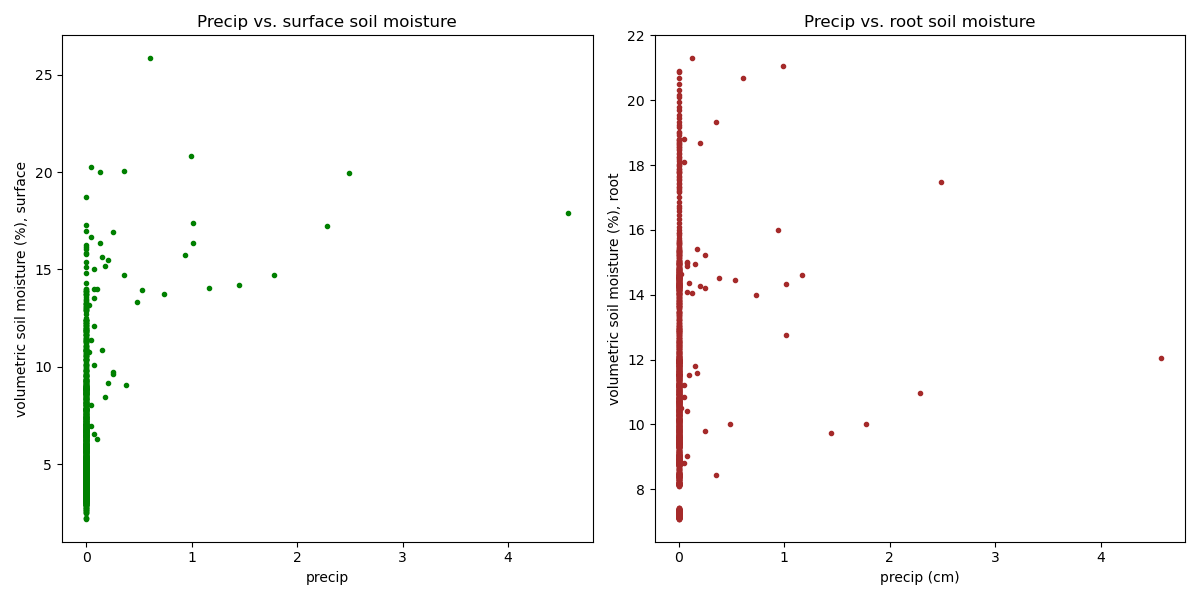

In [10]:
# is there a correlation between precipitation at El Centro and soil moisture down at LS? 
fig =plt.subplots(figsize=(12,6), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(overlap_data[0], overlap_data[1],'.g')
plt.ylabel('volumetric soil moisture (%), surface')
plt.xlabel('precip')
plt.title('Precip vs. surface soil moisture')
plt.subplot(1,2,2)
plt.plot(overlap_data[0], overlap_data[2],'.',color='brown')
plt.ylabel('volumetric soil moisture (%), root')
plt.xlabel('precip (cm)')
plt.title('Precip vs. root soil moisture')
plt.show()

In [ ]:
# when plotting relationship btw sm and tpc, use change in sm or maybe max difference between the three dates, try different things.

In [12]:
# Now extract the soil moisture values that correspond to the days of the SLCs 

# import the dates of the SLCs and make them into datetime objects 
workdir = '/data/ocp4/LagunaSalada/'
cropdir='cropped_9000_1800_18000_3600/' # other option is 'cropped_9000_20_10000_1780/'
dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vh/2*")]
dates=sorted(dates)
#slc_dates=np.ndarray([len(dates)],dtype='datetime64')
slc_dates = []
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
print(str(len(slc_dates))+' SLC dates') 

211 SLC dates


In [13]:
# Read in 2day precipitation data
precip2day = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
#print('i \tdate \t\t       precip > 0.3cm')
print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip2day)): 
    if precip2day[i] > 0.3:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip2day[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.0cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
107	2020-04-12 00:00:00    0.9906 cm
186	2021-08-11 00:00:00    0.381 cm


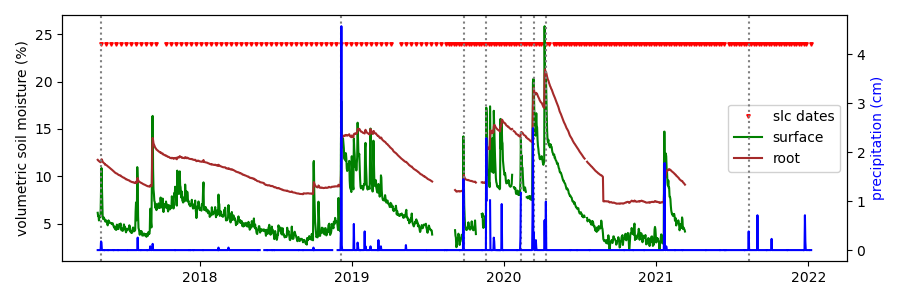

In [15]:
# plot sm, precip data and slc dates 
slc_points = np.zeros([len(slc_dates)], dtype='float')+24

fig, ax1 =plt.subplots(figsize=(9,3), tight_layout=True)
ax1.plot(slc_dates, slc_points,'rv',markersize=2.5,label='slc dates')
ax1.plot(overlap_dates, overlap_data[1,:],'-g',label='surface')
ax1.plot(overlap_dates, overlap_data[2,:],'-',color='brown',label='root')
#ax1.set_xlim([min(slc_dates),max(slc_dates)])
ax1.set_ylabel('volumetric soil moisture (%)')
#ax1.set_xlabel('date')
ax2 = ax1.twinx()
#ax2.plot(overlap_dates, overlap_data[0,:],'-b',label='precip') # just the ones that overlap with SMAP data
ax2.plot(my_dates, precip,'-b',label='precip') # all the precip dates I use/overlap with slc date range

# plot vlines for precip > 0.3 cm 
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])

ax2.set_ylabel('precipitation (cm)',color='b')
ax1.legend(loc='center right',framealpha=0.9)
#ax1.legend(bbox_to_anchor=(0.6,0.5))
#plt.title('SMAP 9km product and precipitation')

# plot the four I show as unwrapped igrams as a line or something different 
# ax1.plot(slc_dates[61], slc_points[61],'rv',markersize=5)
# ax1.plot(slc_dates[47], slc_points[47],'rv',markersize=5)
# ax1.plot(slc_dates[74], slc_points[74],'rv',markersize=5)
# ax1.plot(slc_dates[132], slc_points[132],'rv',markersize=5)

plt.show()

plt.savefig("precip_sm.pdf", transparent=True)

# I think this is right but some dates have nans for either dataset

In [ ]:
# match up SLC dates to soil moisture dates

# find which dates both datasets have in common 
slc_overlap_dates, sm_dates_overlap1, slc_dates_overlap = np.intersect1d(sm_dates, slc_dates, return_indices=True)
num_slc_overlap_dates = len(slc_overlap_dates)
print(str(num_slc_overlap_dates)+' overlapping dates')
print(sm_dates_overlap1)
print(slc_dates_overlap)

In [ ]:
# Read in 2day precipitation data
precip_2day = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
print(len(precip_2day))
# so the slc_dates_overlap indices will the same for precip2day since they correspond with each slc

In [ ]:
# initialize empty array for data on overlapping days to go in 
slc_overlap_data = np.zeros([3, num_slc_overlap_dates], dtype='float')
# first row precip
# second row surface sm 
# third row root sm 

# now loop through these dates that are shared btw datasets 
for i in range(num_slc_overlap_dates):
    slc_overlap_data[0,i] = precip_2day[slc_dates_overlap[i]]
    slc_overlap_data[1,i] = surface_mean[sm_dates_overlap1[i]]
    slc_overlap_data[2,i] = root_mean[sm_dates_overlap1[i]]

In [ ]:
# plot the sm and precip values on the days that overlap with slcs 
fig, ax1 =plt.subplots(figsize=(12,3), tight_layout=True)
ax1.plot(slc_overlap_dates, slc_overlap_data[1,:],'.g',label='surface')
ax1.plot(slc_overlap_dates, slc_overlap_data[2,:],'.',color='brown',label='root')
ax1.plot(slc_dates, slc_points,'r.',label='slc dates')
ax1.set_ylabel('volumetric soil moisture (%)')
ax1.set_xlabel('date')
ax2 = ax1.twinx()
ax2.plot(slc_overlap_dates, slc_overlap_data[0,:],'.b',label='precip')
ax2.set_ylabel('precipitation (cm)',color='b')
ax1.legend()
plt.title('SMAP 9km product and precipitation')
plt.show()
# This looks right!!

In [ ]:
# calculate TPC for each igram (at what location?) 

# at the anomalous area, probably 
x_1=9234   
y_1=1345   
# where else? 
# western shore of LS, one spot in particular closer to bottom 
x_2=14100
y_2=3340
# check cumulative 
# what about near Cerro Prieto? (Geothermal field, next to retention pond) 
# east of retention pond
x_3=2700
y_3=1900
# west of Cerro Prieto
x_4=4500
y_4=2000

In [ ]:
# load the cumulative TPC plot I had made and saved 
# to see which areas are interesting to plot TPC vs. soil moisture to see if any type of relationship 
# load in the file to plot if I haven't run the above code this session
f1 = gdal.Open(workdir+'/5_tpc/cumulative_tpc.r4', gdal.GA_ReadOnly)
tpcCumSkip2 = f1.ReadAsArray()

In [ ]:
#plot cumulative tpc for entire region over entire time period
# for the entire region 
x1=0; y1=0; x2=18000; y2=3600
fig= plt.subplots(1,1,figsize=(8, 8), tight_layout=True)
plt.subplot(1,1,1)
plt.imshow(tpcCumSkip2, vmin=-50, vmax=50, cmap='seismic', aspect='auto', \
                interpolation='nearest', extent = [x1,x2,y2,y1])
# can add vmin=-20, vmax=20, to above line of code 
#plt.plot([x_1,x_2,x_3,x_4],[y_1,y_2,y_3,y_4],'k.',markersize=10)
plt.ylabel('azimuth')
plt.xlabel('range')
plt.colorbar(label='cumulative TPC (radians)')
plt.title("cumulative triplet phase closure (sequential)")
plt.xlim([x2,x1])
plt.ylim([y2,y1])
plt.show()

In [ ]:
# filtering area for calculating TPC, can also use alooks 4, rlooks 20 
alooks=40
rlooks=200
# only pulling out the SLCs that are within the period that overlaps with soil moisture data
imported_data=np.ndarray([num_slc_overlap_dates+1,alooks,rlooks],'complex')
# pull out the alooks x rlooks box of pixels 
# but start at the first slc that overlaps with sm data and end at the last overlapping one 
# the +1 is because we can calculate tpc for the last overlapping day since we have more slcs beyond this time period
for i in np.arange(slc_dates_overlap[0],slc_dates_overlap[-1]+1,1):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full",gdal.GA_ReadOnly)
    imported_data[i,:,:] = ds.GetRasterBand(1).ReadAsArray(x_1-rlooks/2,y_1-alooks/2,rlooks,alooks)
# initialize array for igram data
# only -1 because we have extra slc data for the last overlapping date so we can get a tpc value for that one 
tpc=np.ndarray([num_slc_overlap_dates-1],'complex')

print(str(num_slc_overlap_dates)+' overlapping dates')
print('can get '+str(len(tpc))+' tpc values')

# make igrams
skip1_igrams = imported_data[0:-1,:,:]*np.conj(imported_data[1:,:,:]) 
skip2_igrams = imported_data[2:,:,:]*np.conj(imported_data[0:-2,:,:])
# now average them (same as downlooking)
skip1_igrams = np.mean(skip1_igrams,axis=(1,2)) 
skip2_igrams = np.mean(skip2_igrams,axis=(1,2))

# exclude the 0th term ?
for i in np.arange(0,num_slc_overlap_dates-1,1):
    ab = skip1_igrams[i]
    bc = skip1_igrams[i+1]
    ca = skip2_igrams[i]
    ab = np.exp(1j*np.angle(ab)) # normalizing to length 1
    bc = np.exp(1j*np.angle(bc)) # same as bc/abs(bc)
    ca = np.exp(1j*np.angle(ca))
    tpc[i] = ab*bc*ca

In [ ]:
print(np.shape(skip1_igrams))

In [ ]:
# Calculate average coherence over three SLCs to color each tpc point 
num_igrams = num_slc_overlap_dates-1 # num overlapping slcs-1 is equal to num igrams 
# initialize empty arrays 
coh = np.zeros([num_igrams]) 
# initialize arrays for average coh over 3 dates
cohAvg = np.zeros([num_igrams-2])

# calculate coherence for each date/SLC 
for i in np.arange(0,num_igrams,1): 
    # make interferogram
    int = imported_data[i,:,:] * np.conj(imported_data[i+1,:,:])
    # <a b*> / <abs(a b*)> complex coherence 
    #print(str(i)+'   '+str(np.abs(np.mean(int,axis=(0,1))/np.mean(np.abs(int),axis=(0,1)))))
    coh[i]=np.abs(np.mean(int,axis=(0,1))/np.mean(np.abs(int),axis=(0,1)))

# calculate avg coherence for each triplet
for i in np.arange(num_igrams-2):
    cohAvg[i] = np.mean(coh[i:i+3])

In [ ]:
# plot tpc values over time colored by average coherence over the triplet 
fig, ax1 =plt.subplots(figsize=(12,3), tight_layout=True)
# not going [0,-1] because first date doesn't have tpc value but last one does
ax1.plot(slc_overlap_dates[1:len(slc_overlap_dates)], np.angle(tpc),'m.',label='tpc',zorder=1)
ax1.scatter(slc_overlap_dates[2:len(slc_overlap_dates)-1], np.angle(tpc)[1:-1],c=cohAvg,label='tpc',zorder=10)
ax1.set_ylabel('tpc (radians)')
ax1.set_xlabel('date')
#ax1.set_xlim([slc_overlap_dates[0],slc_overlap_dates[10]]) # this was to test range of data
ax1.legend()
plt.title('tpc over time at ('+str(x_1)+','+str(y_1)+')')
plt.show()

In [ ]:
print(np.shape(slc_overlap_dates))
print(np.shape(slc_overlap_data[1,:]))
print(np.shape(slc_overlap_dates[1:len(slc_overlap_dates)]))
print(np.shape(tpc))

In [ ]:
# is there a correlation between Raw soil moisture values and tpc? No...

fig =plt.subplots(figsize=(12,6), tight_layout=True)
plt.subplot(1,2,1)
#plt.plot(np.angle(tpc), slc_overlap_data[1,1:len(slc_overlap_dates)],'.g')
plt.plot(np.angle(tpc[1:-1]), slc_overlap_data[1,2:len(slc_overlap_dates)-1],c=cohAvg)
plt.ylabel('volumetric soil moisture (%), surface')
plt.xlabel('tpc (radians)')
plt.title('TPC vs. surface soil moisture')
plt.subplot(1,2,2)
plt.plot(np.angle(tpc), slc_overlap_data[2,1:len(slc_overlap_dates)],'.',color='brown',label='root')
plt.ylabel('volumetric soil moisture (%), root')
plt.xlabel('tpc (radians)')
plt.title('TPC vs. root soil moisture')
plt.show()

In [ ]:
# Now calculate max change in sm over the tpc time period rather than raw value 
max_diff_surface = np.ndarray([len(tpc)],dtype='float')
max_diff_root = np.ndarray([len(tpc)],dtype='float')
print(len(slc_overlap_data[1,:]))

for i in np.arange(1,len(tpc)):
    #print(i)
    # this is only data points ON the slc days, we want the in between days too 
    #nums = [slc_overlap_data[1,i-1], slc_overlap_data[1,i], slc_overlap_data[1,i+1]]
    # all sm dates in the tpc date range
    #print(sm_dates_overlap1[i-1])
    #print(sm_dates_overlap1[i+1])
    nums = surface_mean[sm_dates_overlap1[i-1]:sm_dates_overlap1[i+1]]
    #print(len(nums))
    #print(nums)
    max_diff_surface[i] = max(nums)-min(nums)
    #print(max_diff_surface[i])
    nums = root_mean[sm_dates_overlap1[i-1]:sm_dates_overlap1[i+1]]
    max_diff_root[i] = max(nums)-min(nums)
#print(max_diff_surface)   
#print(max_diff_root) 

In [ ]:
print(np.shape(cohAvg))
print(np.shape(tpc))
#print(num

In [ ]:
# is there a correlation between soil moisture changes and tpc? 

fig =plt.subplots(figsize=(12,6), tight_layout=True)
plt.subplot(1,2,1)
#plt.plot(np.angle(tpc), max_diff_surface,'.g')
plt.scatter(np.angle(tpc)[1:-1], max_diff_surface[1:-1],c=cohAvg)
plt.ylabel('max volumetric soil moisture change (%) over triplet, surface')
plt.xlabel('tpc (radians)')
plt.title('TPC vs. \u0394 surface soil moisture')
plt.subplot(1,2,2)
#plt.plot(np.angle(tpc), max_diff_root,'.',color='brown',label='root')
plt.scatter(np.angle(tpc)[1:-1], max_diff_root[1:-1],c=cohAvg)
plt.ylabel('max volumetric soil moisture change (%) over triplet, root')
plt.xlabel('tpc (radians)')
plt.title('TPC vs. \u0394 root soil moisture')
plt.show()

In [ ]:
# try a line of best fit 

# start with removing nans 
max_diff_surface_cleaned = max_diff_surface[np.logical_not(np.isnan(max_diff_surface))]
#print(max_diff_surface_cleaned)
max_diff_root_cleaned = max_diff_root[np.logical_not(np.isnan(max_diff_root))]
# do it for tpc, only pull out the values that have data in sm diff 
tpc_cleaned = tpc[np.logical_not(np.isnan(max_diff_root))]

a, b = np.polyfit(np.angle(tpc_cleaned), max_diff_surface_cleaned, 1)
print(a)
print(b)
x = np.linspace(min(np.angle(tpc_cleaned)), max(np.angle(tpc_cleaned)),2)
y = a*x+b

a1, b1 = np.polyfit(np.angle(tpc_cleaned), max_diff_root_cleaned, 1)
print(a1)
print(b1)
y1 = a1*x+b1

# plot it colored by coherence, maybe lowest of triplet/highest, etc. 
# throw out data that is <-1 
# could also add weights, lower coh for larger tpc values 
# could try coh^1/2 as a weight 

In [ ]:
(np.angle(tpc)[1:-1], max_diff_surface[1:-1],c=cohAvg)

In [ ]:
# is there a correlation between soil moisture changes and tpc? 

fig =plt.subplots(figsize=(8,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(np.angle(tpc_cleaned), max_diff_surface_cleaned,'.g')
plt.plot(x,y,'k-')
plt.ylabel('max volumetric soil moisture change (%) over triplet, surface')
plt.xlabel('tpc (radians)')
plt.title('TPC vs. \u0394 surface soil moisture')
plt.subplot(1,2,2)
plt.plot(np.angle(tpc_cleaned), max_diff_root_cleaned,'.',color='brown',label='root')
plt.plot(x,y1,'k-')
plt.ylabel('max volumetric soil moisture change (%) over triplet, root')
plt.xlabel('tpc (radians)')
plt.title('TPC vs. \u0394 root soil moisture')
plt.show()